# Notebook 02: Exploratory Data Analysis & Preprocessing

### Understand the dataset and prepare it for embedding generation

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
from wordcloud import WordCloud

In [3]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:

# ================================
# 1. LOAD DATA
# ================================

print("Loading dataset...")
df = pd.read_csv('../data/arxiv_papers.csv')
print(f"✓ Loaded {len(df)} papers\n")

Loading dataset...
✓ Loaded 2228 papers



In [5]:
# ================================
# 2. INITIAL DATA EXPLORATION
# ================================

df.head()

,arxiv_id,title,abstract,authors,published_date,categories,pdf_url,query,abstract_length,year
0,1909.03550v1,Lecture Notes: Optimization for Machine Learning,Lecture notes on optimization for machine lear...,Elad Hazan,2019-09-08,"cs.LG, stat.ML",http://arxiv.org/pdf/1909.03550v1,machine learning,180,2019
1,1811.04422v1,An Optimal Control View of Adversarial Machine...,I describe an optimal control view of adversar...,Xiaojin Zhu,2018-11-11,"cs.LG, stat.ML",http://arxiv.org/pdf/1811.04422v1,machine learning,524,2018
2,1707.04849v1,Minimax deviation strategies for machine learn...,The article is devoted to the problem of small...,"Michail Schlesinger, Evgeniy Vodolazskiy",2017-07-16,cs.LG,http://arxiv.org/pdf/1707.04849v1,machine learning,251,2017
3,1909.09246v1,Machine Learning for Clinical Predictive Analy...,"In this chapter, we provide a brief overview o...",Wei-Hung Weng,2019-09-19,"cs.LG, stat.ML",http://arxiv.org/pdf/1909.09246v1,machine learning,839,2019
4,2301.09753v1,Towards Modular Machine Learning Solution Deve...,Machine learning technologies have demonstrate...,"Samiyuru Menik, Lakshmish Ramaswamy",2023-01-23,"cs.LG, cs.SE",http://arxiv.org/pdf/2301.09753v1,machine learning,1252,2023


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   arxiv_id         2228 non-null   object
 1   title            2228 non-null   object
 2   abstract         2228 non-null   object
 3   authors          2228 non-null   object
 4   published_date   2228 non-null   object
 5   categories       2228 non-null   object
 6   pdf_url          2228 non-null   object
 7   query            2228 non-null   object
 8   abstract_length  2228 non-null   int64 
 9   year             2228 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 174.2+ KB


In [7]:
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


DATASET OVERVIEW

Shape: (2228, 10)

Columns: ['arxiv_id', 'title', 'abstract', 'authors', 'published_date', 'categories', 'pdf_url', 'query', 'abstract_length', 'year']

Data types:
arxiv_id           object
title              object
abstract           object
authors            object
published_date     object
categories         object
pdf_url            object
query              object
abstract_length     int64
year                int64
dtype: object

Memory usage: 3.54 MB


In [8]:
# ================================
# 3. TEXT LENGTH ANALYSIS
# ================================

print("\n" + "="*60)
print("TEXT LENGTH ANALYSIS")
print("="*60)

df['title_length'] = df['title'].str.len()
df['abstract_length'] = df['abstract'].str.len()
df['abstract_word_count'] = df['abstract'].str.split().str.len()

print("\nTitle length statistics:")
print(df['title_length'].describe())

print("\nAbstract length statistics:")
print(df['abstract_length'].describe())

print("\nAbstract word count statistics:")
print(df['abstract_word_count'].describe())


TEXT LENGTH ANALYSIS

Title length statistics:
count    2228.000000
mean       70.657092
std        23.483038
min        13.000000
25%        54.000000
50%        69.000000
75%        86.000000
max       185.000000
Name: title_length, dtype: float64

Abstract length statistics:
count    2228.000000
mean      981.642729
std       390.430930
min         3.000000
25%       680.000000
50%      1000.500000
75%      1252.250000
max      1919.000000
Name: abstract_length, dtype: float64

Abstract word count statistics:
count    2228.000000
mean      138.609964
std        54.645784
min         1.000000
25%        96.000000
50%       141.000000
75%       178.000000
max       295.000000
Name: abstract_word_count, dtype: float64



✓ Saved visualization: text_length_distribution.png


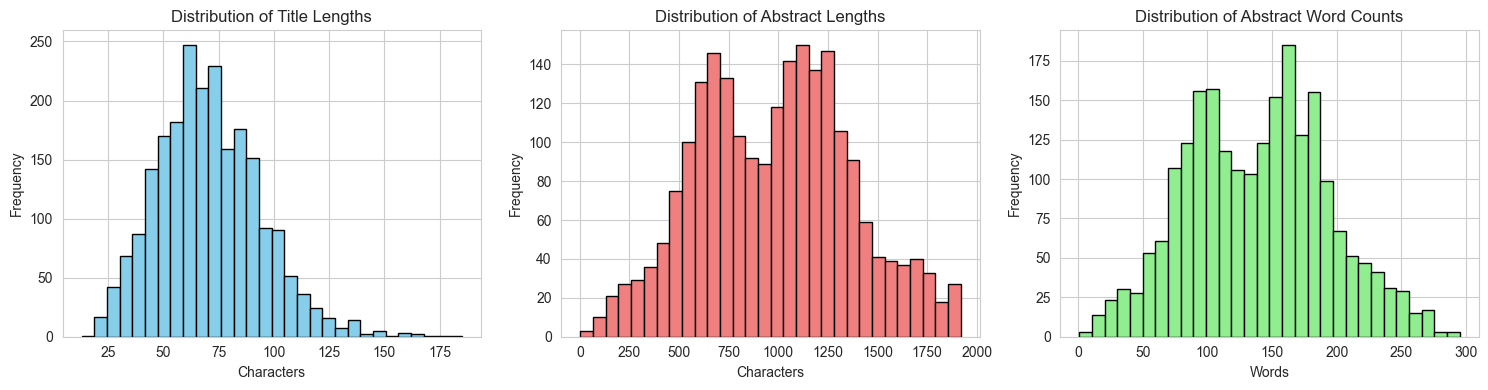

In [9]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['title_length'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Title Lengths')
axes[0].set_xlabel('Characters')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['abstract_length'], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Abstract Lengths')
axes[1].set_xlabel('Characters')
axes[1].set_ylabel('Frequency')

axes[2].hist(df['abstract_word_count'], bins=30, color='lightgreen', edgecolor='black')
axes[2].set_title('Distribution of Abstract Word Counts')
axes[2].set_xlabel('Words')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../data/text_length_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualization: text_length_distribution.png")


In [11]:
# ================================
# 4. TEMPORAL ANALYSIS
# ================================

print("\n" + "="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

df['published_date'] = pd.to_datetime(df['published_date'])
df['year'] = df['published_date'].dt.year
df['month'] = df['published_date'].dt.month

print("\nPapers by year:")
print(df['year'].value_counts().sort_index(ascending=False))




TEMPORAL ANALYSIS

Papers by year:
year
2025    146
2024    231
2023    243
2022    224
2021    228
2020    313
2019    274
2018    227
2017    120
2016     88
2015     39
2014     21
2013     24
2012     15
2011      9
2010      3
2009      5
2008      3
2007      1
2005      2
2003      2
2002      2
2001      1
2000      1
1996      1
1995      5
Name: count, dtype: int64


✓ Saved visualization: papers_by_year.png


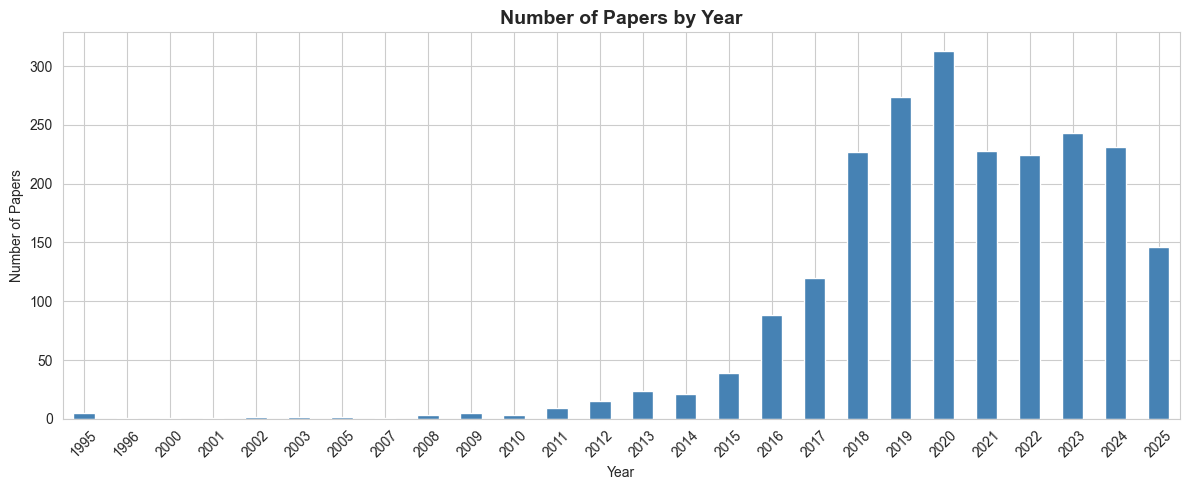

In [12]:
# Visualization
plt.figure(figsize=(12, 5))
df['year'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Number of Papers by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../data/papers_by_year.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: papers_by_year.png")

In [13]:
# ================================
# 5. CATEGORY ANALYSIS
# ================================

print("\n" + "="*60)
print("CATEGORY ANALYSIS")
print("="*60)

# Split categories and count
all_categories = df['categories'].str.split(', ').explode()
category_counts = all_categories.value_counts()

print("\nTop 15 categories:")
print(category_counts.head(15))



CATEGORY ANALYSIS

Top 15 categories:
categories
cs.LG       1614
cs.AI        765
stat.ML      660
cs.CV        319
cs.RO        172
cs.CL        154
cs.SY         89
cs.NE         84
eess.SY       82
cs.CR         59
cs.MA         54
quant-ph      52
cs.CY         49
eess.IV       47
math.OC       47
Name: count, dtype: int64


✓ Saved visualization: top_categories.png


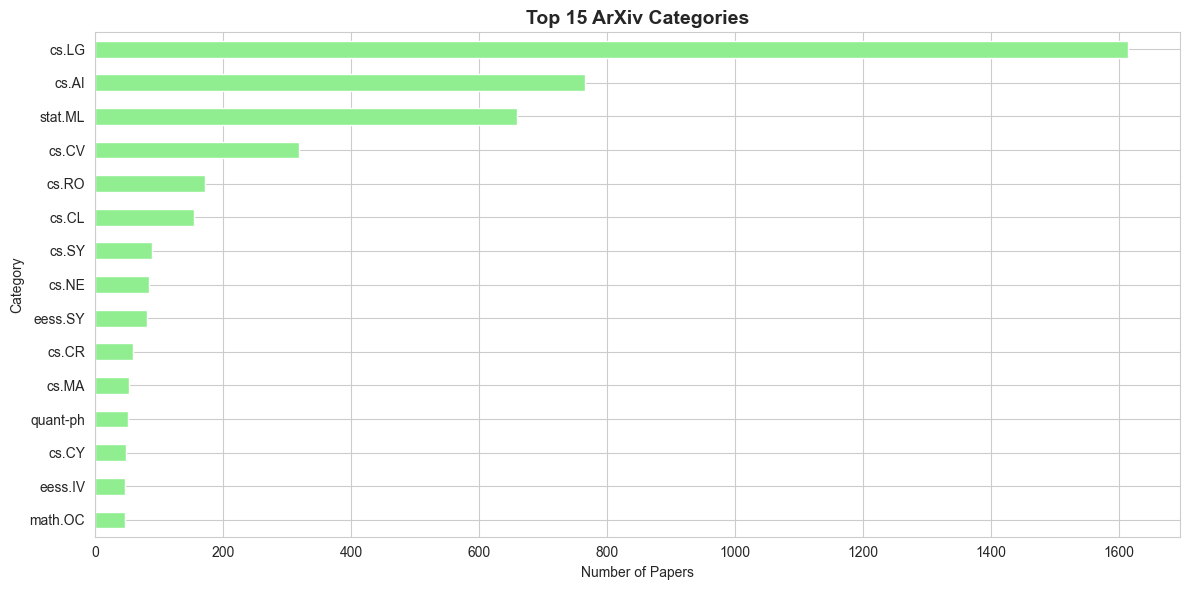

In [19]:
# Visualization
plt.figure(figsize=(12, 6))
category_counts.head(15).plot(kind='barh', color='lightgreen')
plt.title('Top 15 ArXiv Categories', fontsize=14, fontweight='bold')
plt.xlabel('Number of Papers')
plt.ylabel('Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../data/top_categories.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: top_categories.png")

In [21]:

# ================================
# 6. AUTHOR ANALYSIS
# ================================

print("\n" + "="*60)
print("AUTHOR ANALYSIS")
print("="*60)

df['num_authors'] = df['authors'].str.split(', ').str.len()

print("\nAuthor count statistics:")
print(df['num_authors'].describe())

print("\nDistribution of author counts:")
print(df['num_authors'].value_counts().head(10))





AUTHOR ANALYSIS

Author count statistics:
count    2228.000000
mean        3.300718
std         2.073040
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        26.000000
Name: num_authors, dtype: float64

Distribution of author counts:
num_authors
2     526
3     472
1     383
4     367
5     216
6     122
7      60
8      28
9      20
10     19
Name: count, dtype: int64


In [22]:
# Most prolific authors
all_authors = df['authors'].str.split(', ').explode()
print("\nTop 10 most prolific authors:")
print(all_authors.value_counts().head(10))


Top 10 most prolific authors:
authors
Sergey Levine           19
Doina Precup            11
Chelsea Finn             9
Aske Plaat               9
Matthew E. Taylor        9
Bo Liu                   7
Xin Wang                 7
Akshay Krishnamurthy     7
Yang Yu                  7
David Abel               6
Name: count, dtype: int64


In [23]:
# ================================
# 7. TEXT QUALITY CHECKS
# ================================

print("\n" + "="*60)
print("TEXT QUALITY CHECKS")
print("="*60)

# Check for very short abstracts (potential data quality issues)
short_abstracts = df[df['abstract_word_count'] < 50]
print(f"\nPapers with very short abstracts (<50 words): {len(short_abstracts)}")

# Check for missing data
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate titles: {df['title'].duplicated().sum()}")
print(f"Duplicate abstracts: {df['abstract'].duplicated().sum()}")


TEXT QUALITY CHECKS

Papers with very short abstracts (<50 words): 98

Missing values per column:
arxiv_id               0
title                  0
abstract               0
authors                0
published_date         0
categories             0
pdf_url                0
query                  0
abstract_length        0
year                   0
title_length           0
abstract_word_count    0
month                  0
num_authors            0
dtype: int64

Duplicate titles: 1
Duplicate abstracts: 0


In [34]:
# ================================
# 8. KEYWORD EXTRACTION (Simple)
# ================================

print("\n" + "="*60)
print("COMMON KEYWORDS IN ABSTRACTS")
print("="*60)

# Simple keyword extraction
def extract_keywords(text):
    """Extract potential keywords from text"""
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Split into words
    words = text.split()
    
    # Remove common stop words and short words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                  'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'been', 'be',
                  'this', 'that', 'these', 'those', 'we', 'our', 'which', 'can', 'has','however','their'}
    
    keywords = [w for w in words if len(w) > 3 and w not in stop_words]
    return keywords

# Extract keywords from all abstracts
all_keywords = []
for abstract in df['abstract']:
    all_keywords.extend(extract_keywords(abstract))

keyword_freq = Counter(all_keywords)
print("\nTop 30 keywords:")
for keyword, count in keyword_freq.most_common(30):
    print(f"  {keyword}: {count}")


COMMON KEYWORDS IN ABSTRACTS

Top 30 keywords:
  learning: 9376
  deep: 3538
  reinforcement: 3361
  machine: 2067
  models: 1458
  data: 1363
  methods: 1064
  model: 1052
  paper: 1001
  algorithms: 988
  vision: 979
  tasks: 967
  performance: 914
  have: 863
  such: 826
  using: 806
  training: 759
  neural: 741
  results: 697
  language: 696
  networks: 683
  approach: 681
  algorithm: 659
  research: 625
  based: 621
  framework: 619
  method: 609
  problem: 598
  propose: 592
  show: 582


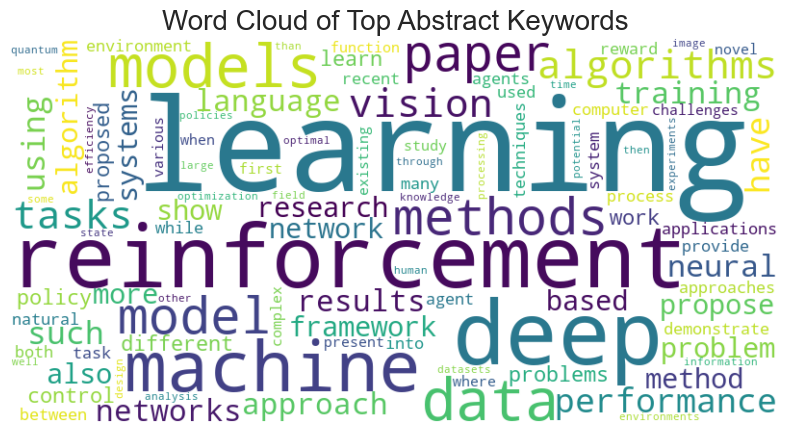

In [35]:
# ================================
#  WORD CLOUD GENERATION
# ================================

# Convert the Counter object (keyword_freq) into a dictionary for WordCloud
wordcloud_data = dict(keyword_freq.most_common(100)) # Use top 100 for a cleaner cloud

# Create the WordCloud object
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='viridis', # Choose a color scheme
    # We pass the calculated frequencies directly
).generate_from_frequencies(wordcloud_data)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Hide the axes
plt.title('Word Cloud of Top Abstract Keywords', fontsize=20)
plt.show()

# Optional: Save the word cloud image
# wordcloud.to_file("../reports/keyword_wordcloud.png")
# print("Word Cloud saved to ../reports/keyword_wordcloud.png")

In [36]:

# ================================
# 9. DATA CLEANING & PREPROCESSING
# ================================

print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

initial_count = len(df)

# Remove papers with very short abstracts
df_clean = df[df['abstract_word_count'] >= 50].copy()
print(f"Removed {initial_count - len(df_clean)} papers with <50 words in abstract")

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['abstract'])
print(f"Removed {len(df) - len(df_clean)} duplicate abstracts")

# Clean text: remove extra whitespace
df_clean['abstract_clean'] = df_clean['abstract'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_clean['title_clean'] = df_clean['title'].str.replace(r'\s+', ' ', regex=True).str.strip()

print(f"\nFinal dataset size: {len(df_clean)} papers")



DATA CLEANING
Removed 98 papers with <50 words in abstract
Removed 98 duplicate abstracts

Final dataset size: 2130 papers


In [37]:

# ================================
# 10. SAVE CLEANED DATA
# ================================

df_clean.to_csv('../data/arxiv_papers_clean.csv', index=False)
print(f"\n✅ Cleaned data saved to ../data/arxiv_papers_clean.csv")



✅ Cleaned data saved to ../data/arxiv_papers_clean.csv


In [38]:

# ================================
# 11. SUMMARY STATISTICS FOR REPORT
# ================================

print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)

summary_stats = {
    'Total Papers': len(df_clean),
    'Date Range': f"{df_clean['published_date'].min().date()} to {df_clean['published_date'].max().date()}",
    'Avg Abstract Length (words)': f"{df_clean['abstract_word_count'].mean():.1f}",
    'Unique Categories': len(all_categories.unique()),
    'Avg Authors per Paper': f"{df_clean['num_authors'].mean():.1f}",
    'Most Common Category': category_counts.index[0]
}

for key, value in summary_stats.items():
    print(f"{key}: {value}")

print("\n" + "="*60)
print("EDA COMPLETE!")
print("Ready for embedding generation in notebook 03")
print("="*60)


FINAL DATASET SUMMARY
Total Papers: 2130
Date Range: 1995-01-01 to 2025-09-26
Avg Abstract Length (words): 143.5
Unique Categories: 261
Avg Authors per Paper: 3.4
Most Common Category: cs.LG

EDA COMPLETE!
Ready for embedding generation in notebook 03
